---
title: "期末实验 ipynb 文件"
author: pxz
date: 2024-12-26
format:
  html:
    toc: true
    html-math-method: katex
    css: styles.css
---

# 准备
## debug notes
`torch` 当中将向量、矩阵、张量统称为张量，所以下文也不再特意区分；

`xxx.data` 访问张量中的数据。如果 `xxx` 是一个 Variable，`.data` 会返回其底层的 Tensor  
但是，Variable 是在 PyTorch 0.4 之前版本中使用的旧术语，现在被 Tensor 替代  
对于 PyTorch 0.4 及以后的版本，`.data` 已经被弃用  
如果有这种需求，可以改用 `.detach()` 方法  
但是 `.detach()` 有个副作用，就是会清空这个张量已经计算好的梯度  
解决方式是 `x.clone().detach()` 用新建副本绕开原张量

## 环境
随机种子选择：34 是我读小学期间的班内学号  
保持画图内嵌显示  
选择支持中文的字体  
解决负号'-'显示为方块的问题

In [21]:
import torch
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(34)
print(torch.__version__)
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 3)
plt.rcParams['figure.dpi'] = 300

2.5.1+cpu


## 数据

$n=1024 \quad m=512 \quad \mu = 0.01 \quad A \in \mathbb{R}^{m \times n} \quad b \in \mathbb{R}^m$

```python
A = torch.randn(m,n)  随机生成 m 行 n 列的矩阵
u = torch.randn(n)*(torch.rand(n)<0.1)
b = A @ u
```
`rand` 是均匀分布，`randn` 是正态分布  
`(torch.rand(n)<0.1)` 作为乘子意思是随机保留 10% 的数  
前后乘起来得到 `u` 就是正态分布随机保留 10%

In [22]:
n = 1024; m = 512; mu = 0.01
A = torch.randn(m,n)
u = torch.randn(n)*(torch.rand(n)<0.1)
b = A @ u

## 规定超参
### 回溯线搜索
$\alpha$ 是我们可以接受函数每次下降至少要陡到梯度的多少倍（介于 $0$ 到 $1$ 之间）

如果步长导致下降不够陡，不可接受，缩减步长，新步长和旧步长之比记作 $\beta$

针对标准正态分布生成的数据，初始步长 $t$ 设为 $1$ 在数量级上是合理的

In [23]:
alpha = 0.05; beta = 0.7; t=1

### 停机准则
`max_iter` 是最大迭代次数，达到该次数则无条件结束迭代

$\varepsilon$ 是用新旧点二范数之差来衡量是否已足够接近收敛的指标，低过此阈值则停机

In [24]:
max_iter=800; epsilon=1e-6

### ADMM 参数
针对标准正态分布生成的数据，罚因子 $\rho$ 设为 $1$ 在数量级上是合理的

Lagrange 乘子更新的步长 $\tau$ 满足 $0<\tau<\dfrac{1+\sqrt{5}}{2}$ 即可收敛，为方便运算和表示，取此范围内唯一整数 $1$

In [25]:
rho=1; tau=1

{{< pagebreak >}}

## 规定函数

### 特殊形式软阈值算子

**具有步长和一次惩罚项实际意义**

根据 **Handout 4**，既然 $\mu>0$ 且 $h(x)=\mu \|x\|_1$ 那么
$$
\operatorname{prox}_{h,t}(x)=S_\mu (x)
$$
**但**这只是步长 $t=1$ **不变**时的情况  
在步长动态变化（例如精确线搜索和回溯线搜索）时，$h(x)=\|\mu x\|_1$  
从 <u>中文辅助教材（文再文等）例 8.1</u> 进一步推论有：

邻近算子 $u=\operatorname{prox}_{t,h}(x)$ 的最优性条件为
$$
\begin{aligned}
x-u &\in t \partial h(u)
\\
\text{ 即 } x-u &\in t \partial\|\mu x\|_1
\\
\text{ 即 } x-u &\in t \mu \partial\| x\|_1
\begin{cases}
\{t\} &u>0
\\
[-t,t] \quad &u=0
\\
\{-t\} &u<0
\end{cases}
\end{aligned}
$$
这里用 $u$ 是为了和书上的 notation 一致，和实验题目中的 `u` 没有关系
$$
\text{所以 }
[S_{t\mu} (x)]_i=
\begin{cases}
x_i-t\mu \quad &\text{if }\quad x_i>t\mu
\\
0 \quad &\text{if }\quad -t\mu \leq x_i \leq t\mu
\\
x_i+t\mu \quad &\text{if }\quad x_i<-t\mu
\end{cases}
$$
$$
G_t(x)
=\dfrac{x-\operatorname{prox}_{h,t}(x-t\nabla g(x))}{t}
=\dfrac{x-S_{t\mu} [x-t\nabla g(x)]_i^{\text{用分量表示向量}}}{t}
$$

In [26]:
def S(x,t):
    return torch.sign(x) * torch.clamp(torch.abs(x) - t*mu, min=0)
def G(x,t):
    return ( x-S(x-t*x.grad,t) )/t

这个通过符号函数和设置下限来实现软阈值逻辑的想法**可从**<u>中文辅助教材（文再文等）例 8.1</u> **找到**

`torch.sign(z)` 返回输入张量 $z$ 中每个元素的符号

如果 $z_i$ 是正数，返回 $1$；如果是负数，返回 $-1$；如果是 $0$，则返回 $0$

`torch.abs(z)` 返回输入张量 $z$ 中每个元素的绝对值，这样用 `torch.abs(z) - mu` 就可以保证得到的差值肯定是个正的数值，差值是 $z_i$ 和 $\mu_i$ 的绝对值之差的绝对值

`torch.clamp` 函数将输入张量中的元素限制在指定的范围内。在这里，它将所有小于 $0$ 的值设置为 $0$，所以它是以 $0$ 为下限的非负值

再乘以符号函数，实现了 $x_i$ 正归正，负归负

### 一般形式软阈值算子

对于 $S_\lambda (\beta)=\operatorname{argmin}_z \dfrac{1}{2} \|\beta-z\|^2_2 +\lambda \|z\|_1$ 有

$$
[S_\lambda (\beta)]_i=
\begin{cases}
\beta_i -\lambda    &\text{if} \quad \beta_i > \lambda
\\
0               &\text{if} \quad -\lambda \leq \beta_i \leq \lambda
\\
\beta_i +\lambda    &\text{if} \quad \beta_i < -\lambda
\end{cases}
$$

以下代码解释参考上文《特殊形式软阈值算子》

In [27]:
def SS(beta,lmbd):
    return torch.sign(beta) * torch.clamp(torch.abs(beta) - lmbd, min=0)

### 目标函数

$$
\min_x\mu\|x\|_1+\|Ax-b\|_2^2
$$

`x.requires_grad_(True)` 以免求解时遭遇各种各样意想不到的「无梯度」报错

In [28]:
def g(x):  # 可微的项
    x.requires_grad_(True)
    return torch.norm(A@x-b,p=2)**2
def h(x):  # 不可微的项
    return mu*torch.norm(x, p=1)
def f(x):  # 完整的损失函数
    return g(x)+h(x)

### 余弦相似度

In [29]:
def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

## 画图模块

In [30]:
def draw(flist):
     # 将列表中的每个张量转换为NumPy数组
    flist_numpy = np.array([t.detach().numpy() for t in flist])
     # 对数组中的每个元素取自然对数
    log_flist = np.log(flist_numpy)
    plt.figure()
    plt.plot(log_flist)
    plt.xlabel('迭代次数')
    plt.ylabel('目标函数值的自然对数')
    plt.title('Log Scale 上的收敛速度')

# 求解模块
## 近端梯度下降
也即 **ISTA**

In [31]:
def PGD(x,max_iter=max_iter,alpha=alpha,beta=beta,eps=epsilon,t=t):
    f_all=[]
    x_all=[]
    x_all.append( x.clone().detach().numpy() )
    for i in range( int(max_iter) ):
        gg=g(x); ff=f(x)
        f_all.append(ff)
        gg.backward()

        while True:
            with torch.no_grad():
             # 这是个上下文管理器，表示在这个缩进块内不需要计算梯度
             # 更新参数不需要梯度
                x_new = x - t*G(x,t) #S(x,t)
            if g(x_new) <= (
                    gg - t * torch.sum( x.grad*G(x,t) ) + alpha*t*(
                    torch.norm( G(x,t), p=2, dim=0 )
                )**2    ):
                 # 一旦满足回溯线搜索想要的条件，就接受这个新的参数作为更新，并退出
                x_old = x.clone().detach()
                x = x_new
                break
             # 如果不满足（免于退出），就缩减步长，然后又看需不需要再缩减
            t=t*beta

        x_all.append(x.clone().detach().numpy())
        
        iter_norm = torch.abs(torch.norm(x) - torch.norm(x_old))
        if iter_norm < eps:
            return x, f_all, x_all

    return x, f_all, x_all

## Nesterov 加速
也即 **FISTA**

将书上的 notation 改成本题使用的，中文教材 条件 $(8.2.2)$ 可写成  
（同时也是参考课件《06-近端梯度下降与加速》第 26 页的写法）
$$
g(x^+) \geq g(v) + \nabla g(v)^T (x^+ -v) + \dfrac{1}{2t} \|x^+ -v\|^2_2
$$
若转换成代码，其中
$x^+$ 写作 `x_new`，$v$ 写作 `x_v`，
即转换为

```python
g(x_new) <= ( gg +  torch.sum( x_v.grad * (x_new - x_v) )
            + ( 1/(2*t) ) * ( torch.norm( x_new - x_v,ord=2,dim=0 ) )**2
            )
```

相应地，$x^{(x-1)}$ 写作 `x_old`，

$$
v=x^{(x-1)} + \dfrac{k-2}{k+1}
\left(x^{(k-1)} - x^{(k-2)}\right)
$$

$$
x^{(k)} = \operatorname{prox}_{t_k}
\left(
v - t_k \nabla g(v)
\right)
$$

写作

```python
x_v = ( x + (i-2)/(i+1)*(x-x_old) )
x_new = S(x_v-t*x_v.grad,t)
```

In [32]:
def FISTA(x,max_iter=max_iter,beta=beta,eps=epsilon,t=t):
    f_all=[]
    x_all=[]
    x_all.append( x.clone().detach().numpy() )
    x_old = x.clone().detach() 
    x_old.requires_grad = True; x_old.requires_grad_(True)
    for i in range(1,int(max_iter)+1):  # 不能从 0 开始
        #  FISTA 两阶段法的第一阶段，沿前两步方向找一个新的点
        x_v = ( x + (i-2)/(i+1)*(x-x_old) )
        x_v = x_v.clone().detach().requires_grad_(True)

        gg=g(x_v); ff=f(x)
        f_all.append(ff)
        gg.backward()
        x_old.requires_grad = True; x_old.requires_grad_(True)
        
        while True:
            with torch.no_grad():
             # 这是个上下文管理器，表示在这个缩进块内不需要计算梯度
             # 更新参数不需要梯度
                x_new = S(x_v-t*x_v.grad,t)
            if g(x_new) <= (
                    gg + torch.sum( x_v.grad * (x_new - x_v) )
                    + ( 1/(2*t) ) * ( torch.norm( x_new - x_v,p=2,dim=0 ) )**2
                ):
                #  一旦满足回溯线搜索想要的条件，就接受这个新的参数作为更新，并退出
                x_old = x.clone().detach()
                x = x_new
                break
             # 如果不满足（免于退出），就缩减步长，然后又看需不需要再缩减
            t=t*beta

        x_all.append(x.clone().detach().numpy())

        iter_norm = torch.abs(torch.norm(x) - torch.norm(x_old))
        if iter_norm < eps:
            return x, f_all, x_all

    return x, f_all, x_all

{{< pagebreak >}}

## 交替方向乘子法
从 Stephen P. Boyd 等人的 Slides（September 2010）第 17 页得知，在 ADMM 算法迭代中，

对于 $\dfrac{1}{2} \|Ax-b\|_2^2 + \lambda \|x\|_1$ 有
$$
\begin{aligned}
x^{(k+1)}&:=(A^TA+\rho I)^{-1}(A^Tb+\rho z^{(k)}-y^{(k)})
\\
z^{(k+1)}&:=S_{\lambda/\rho}(x^{(k+1)}+y^{(k)}/\rho)
\\
y^{(k+1)}&:=y^{(k)}+\rho(x^{k+1}-z^{(k+1)})
\end{aligned}
$$
**但是**，这里的二次可微项系数是 $\frac{1}{2}$，我们求解问题的二次可微项系数是 $1$，不可直接照搬

以下从原问题出发重新推导所求问题

记 $g(x)=\|Ax-b\|^2_2 \quad h(x)=\mu \|x\|_1 \quad f(x)=g(x)+h(x)$

则原问题写作 $\enspace \min_x f(x)$

现改写为 $\enspace \min_{x,z} g(x)+h(z) \quad \text{s. t.} \enspace x-z=0$

若 $x-z=0$ 化为 $A_1 x + A_2 z = b$ 的标准形式，则
$\begin{cases}
A_1&=1
\\
A_2&=-1
\\
b&=0
\end{cases}$

记 Lagrange 乘子为 $y \quad$ 罚因子为 $\rho \quad$ 固定步长为 $\tau$

对改写形式构造增广 Lagrange 函数

$$
L_\rho = g(x)+h(z)+ y^T (x-z) + \frac{\rho}{2} \|x-z\|^2_2
$$

对于每次迭代

第一步

$$
\begin{aligned}
x^{(k+1)}&=\operatorname{argmin}_x L_\rho (x,z^{(k)},y^{(k)})
\\
&=\operatorname{argmin}_x \left\{
    \|Ax-b\|^2_2 +\mu \|z\|_1 +(y^{(k)})^T (x-z^{(k)}) + \frac{\rho}{2} \|x-z^{(k)}\|^2_2
    \right\}
\\
\Rightarrow \quad& \frac{\partial L}{\partial x} = 2 A^T (Ax-b) +y^{(k)} +\rho(x-z^{(k)})
\\
\text{令 } \frac{\partial L}{\partial x} &=0 \text{ 则 }
2 A^T Ax - 2A^T b +y^{(k)} + \rho x - \rho z^{(k)} =0
\\
\Rightarrow \quad& (2 A^T A + \rho I)x - 2 A^T b + y^{(k)} - \rho z^{(k)} =0
\\
\Rightarrow \quad& (2 A^T A + \rho I)x = 2 A^T b + \rho z^{(k)} - y^{(k)}
\\
\Rightarrow \quad& x^{(k+1)}= (2 A^T A + \rho I)^{-1} (2 A^T b + \rho z^{(k)} - y^{(k)})
\end{aligned}
$$

{{< pagebreak >}}

第二步

$$
\begin{aligned}
z^{(k+1)}&=\operatorname{argmin}_z L_\rho \left(  x^{(k+1)},z,y^{(k)}  \right)
\\
&=\operatorname{argmin}_z\left\{
    \|Ax^{(k+1)} -b\|^2_2 +\mu \|z\|_1 
    + (y^{(k)})^T (x^{(k+1)}-z)
    + \frac{\rho}{2} \|x^{(k+1)}-z\|^2_2
    \right\}
\\
&=\operatorname{argmin}_z\left\{
    \mu \|z\|_1
    + (y^{(k)})^T (x^{(k+1)}-z)
    + \frac{\rho}{2} \|x^{(k+1)}-z\|^2_2
    \right\}
\\ \quad \\
&\text{对要找最值点的目标乘以常数} \frac{2}{\rho}
\\ \quad \\
&=\operatorname{argmin}_z\left\{
    \frac{2 \mu}{\rho} \|z\|_1
    + \frac{2}{\rho} (y^{(k)})^T (x^{(k+1)}-z)
    + \|x^{(k+1)}-z\|^2_2
    \right\}
\\ \quad \\
&=\operatorname{argmin}_z\left\{
    \frac{2 \mu}{\rho} \|z\|_1
    + 2 \left(\frac{y^{(k)}}{\rho}\right)^T (x^{(k+1)}-z)
    + \|x^{(k+1)}-z\|^2_2
    \right\}
\\ \quad \\
&\text{加上与 } z \text{ 无关的项 } \left\|\frac{y^{(k)}}{\rho}\right\|^2_2
\\ \quad \\
&=\operatorname{argmin}_z\left\{
    \frac{2 \mu}{\rho} \|z\|_1
    + \left\|\frac{y^{(k)}}{\rho}\right\|^2_2
    + 2 \left(\frac{y^{(k)}}{\rho}\right)^T (x^{(k+1)}-z)
    + \|x^{(k+1)}-z\|^2_2
    \right\}
\\ \quad \\
&=\operatorname{argmin}_z\left\{
    \frac{2 \mu}{\rho} \|z\|_1
    + \left\|
        \frac{y^{(k)}}{\rho}
        + x^{(k+1)}-z
    \right\|^2_2
    \right\}
\\ \quad \\
&=\operatorname{argmin}_z\left\{
    \frac{1}{2} \left\|
        z-\left(
            x^{(k+1)} + \frac{y^{(k)}}{\rho}
        \right)
    \right\|^2_2
    +\frac{\mu}{\rho} \|z\|_1
    \right\}
\\ \quad \\
&=S_{\left(\frac{\mu}{\rho}\right)} \left(
    x^{(k+1)}+\frac{y^{(k)}}{\rho}
\right)
\qquad \text{其中 } S_{(\cdot)} (\cdot) \text{ 表示软阈值算子}
\end{aligned}
$$

第三步

$$
y^{(k+1)}=y^{(k)}+\tau \rho (x^{(k+1)}-z^{(k+1)})
$$

---

{{< pagebreak >}}

总结

$$
\begin{aligned}
x^{(k+1)}&= (2 A^T A + \rho I)^{-1} (2 A^T b + \rho z^{(k)} - y^{(k)})
\\ \quad \\
z^{(k+1)}&=S_{\left(\frac{\mu}{\rho}\right)} \left(
    x^{(k+1)}+\frac{y^{(k)}}{\rho}
\right)
\\ \quad \\
y^{(k+1)}&=y^{(k)}+\tau \rho (x^{(k+1)}-z^{(k+1)})
\end{aligned}
$$

In [33]:
def ADMM(x,max_iter=max_iter,eps=epsilon,t=t,rho=rho):
    f_all=[]
    x_all=[]
    x_all.append( x.clone().detach().numpy() )
    z = x.clone().detach() 
    z.requires_grad = True; z.requires_grad_(True)
    y = torch.zeros_like(x)  # 初始的 Lagrange 乘子设为零，形状和 x 对齐
    for i in range(1,int(max_iter)+1):
        #  calculate the loss 
        ff = g(x) + h(z)
        f_all.append(ff)
        x_old = x.clone().detach()
        x = torch.linalg.inv(2* A.T @ A + rho*torch.eye(n)) @ (2*A.T @ b + rho*z -y)
        z = SS(x+y/rho,mu/rho)
        y = y + tau * rho * (x-z)
        iter_norm = torch.abs(torch.norm(x) - torch.norm(x_old))
        if iter_norm < eps:
            return x, f_all, x_all
        x_all.append(x.data.cpu().numpy())

    return x, f_all, x_all

{{< pagebreak >}}

# 运行＆分开画图
选分量全是零的向量作初始的 $x$

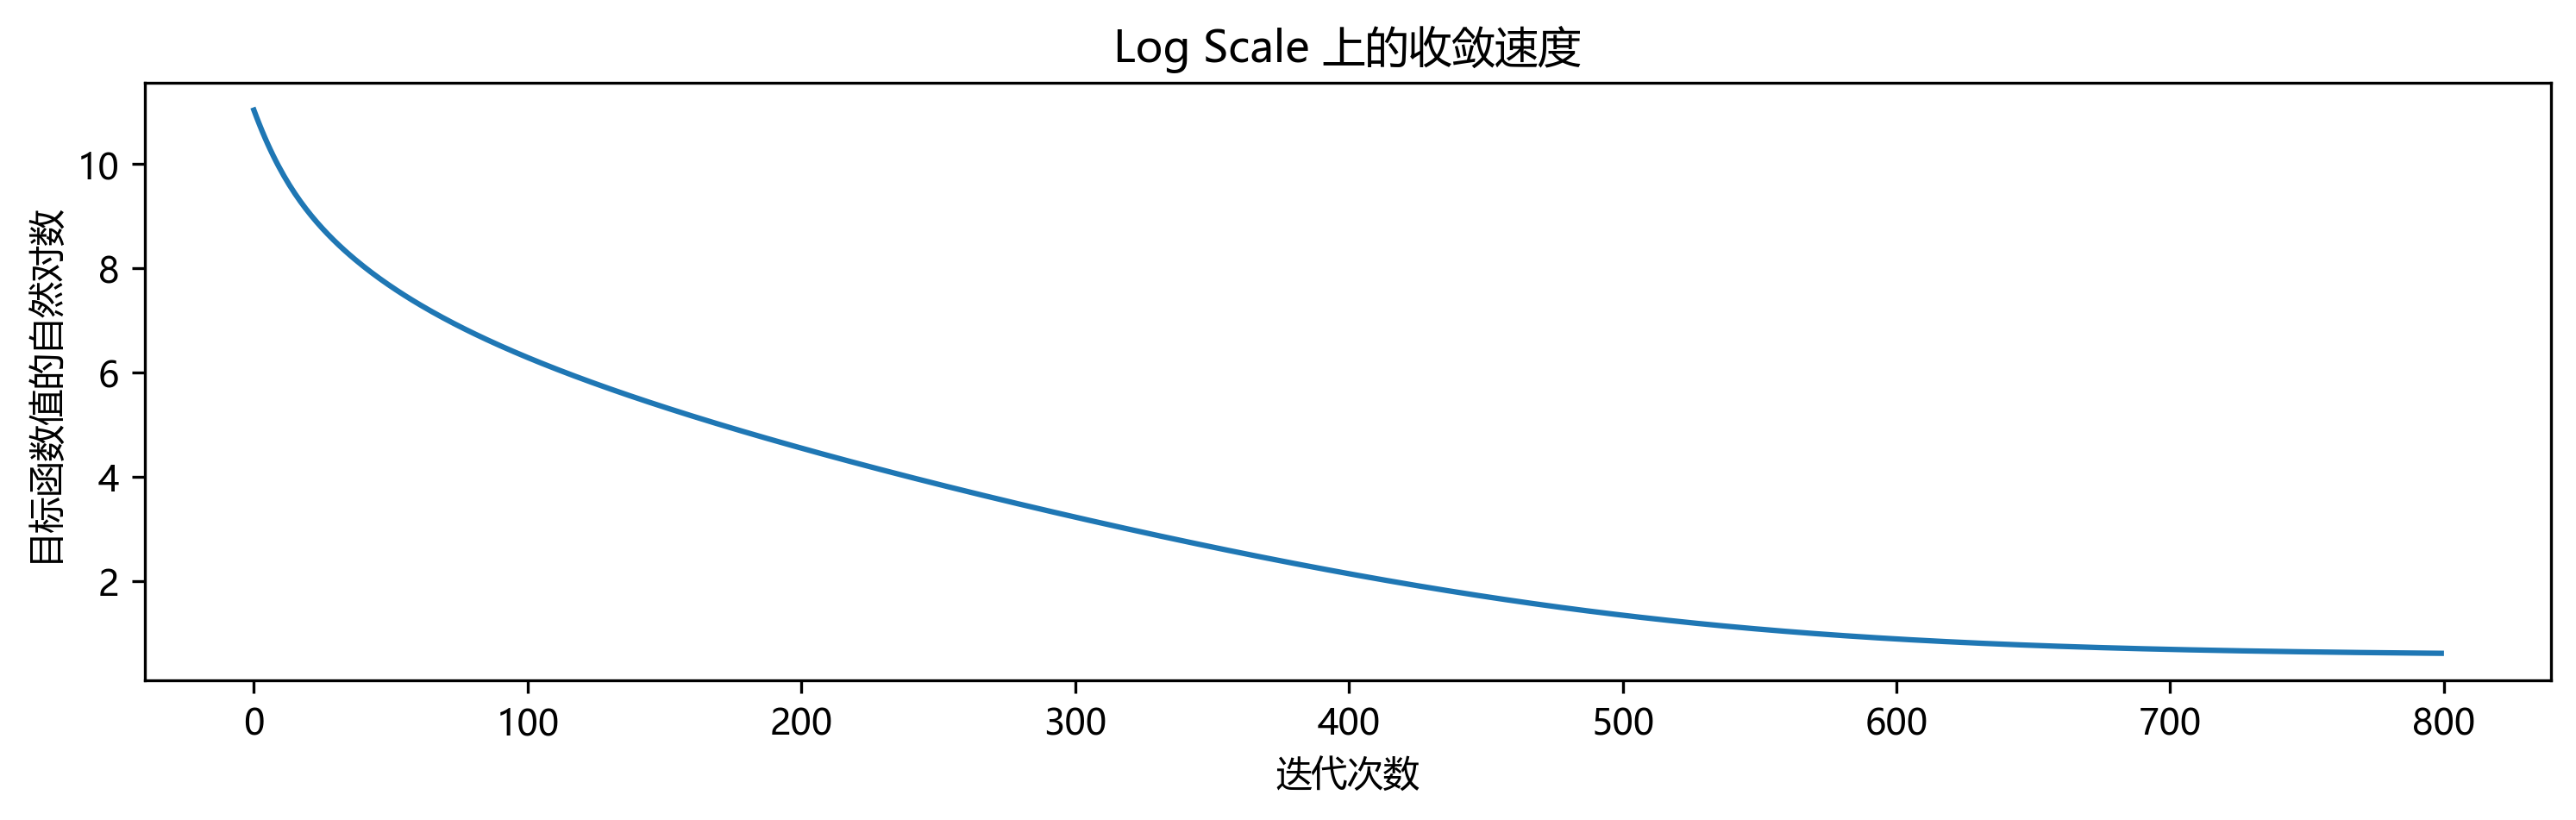

In [34]:
x=torch.zeros(n).requires_grad_(True)
x_star_PGD, f_all_PGD, x_all_PGD = PGD(x)
draw(f_all_PGD)
plt.savefig('PGD',dpi=500,bbox_inches='tight')
plt.show()

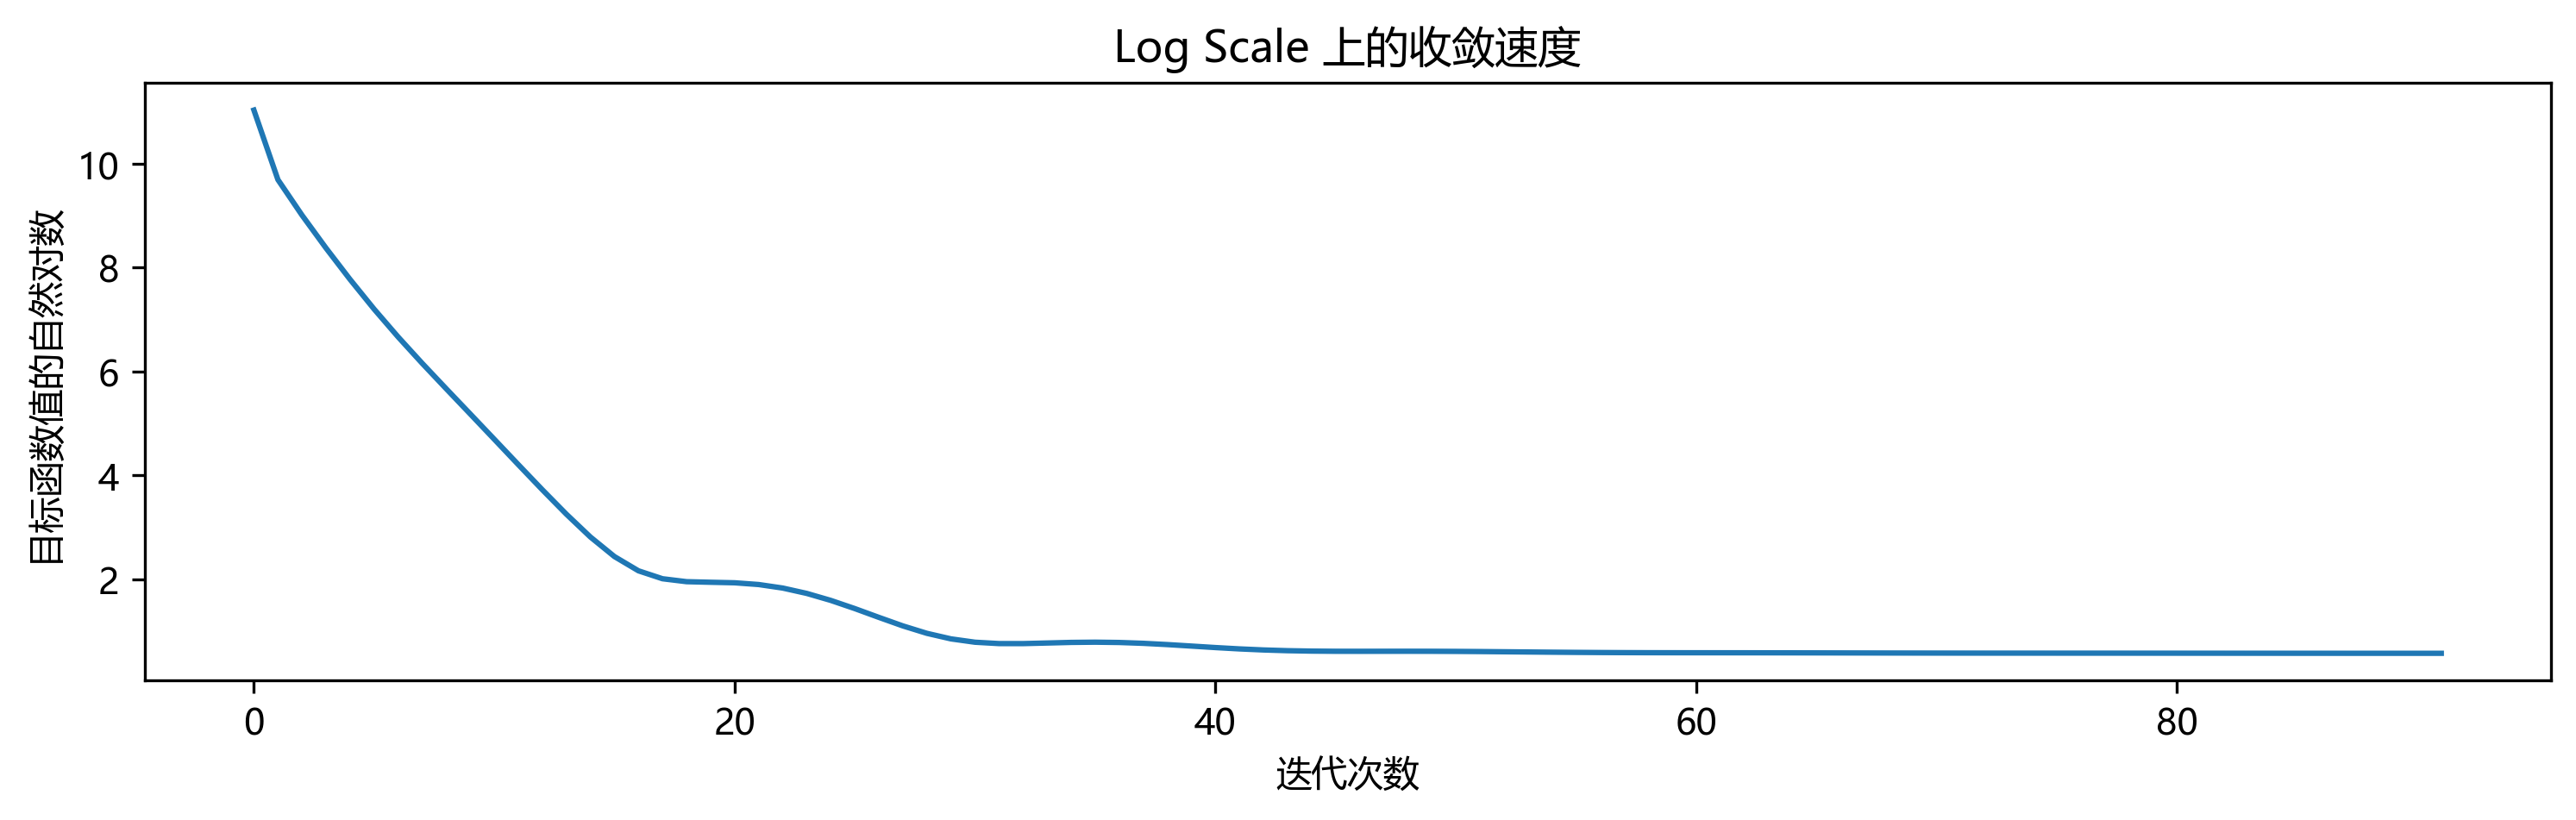

In [35]:
x=torch.zeros(n).requires_grad_(True)
x_star_FISTA, f_all_FISTA, x_all_FISTA = FISTA(x)
draw(f_all_FISTA)
plt.savefig('FISTA',dpi=500,bbox_inches='tight')
plt.show()

{{< pagebreak >}}

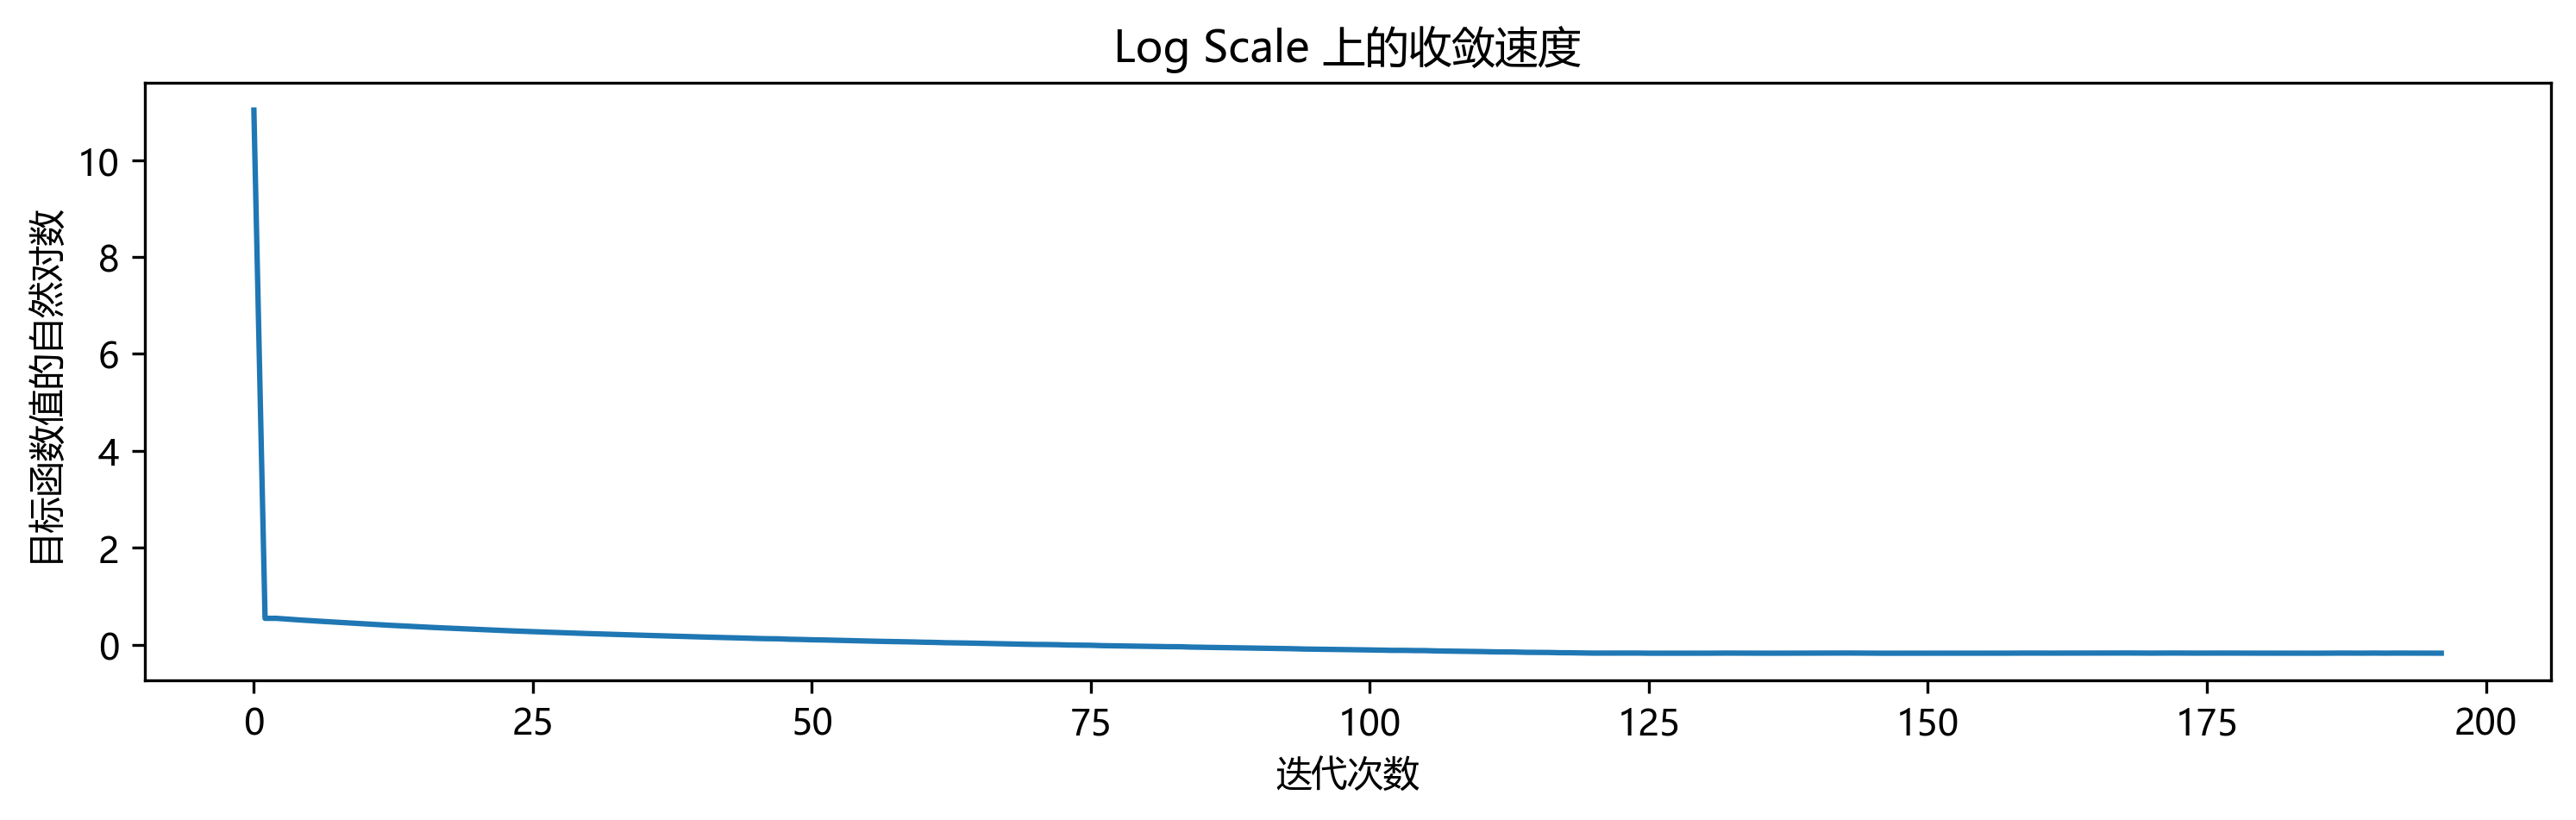

In [36]:
x=torch.zeros(n).requires_grad_(True)
x_star_ADMM, f_all_ADMM, x_all_ADMM = ADMM(x)
draw(f_all_ADMM)
plt.savefig('ADMM',dpi=500,bbox_inches='tight')
plt.show()

# 合并画图

In [37]:
def trans(flist):
    # 将列表中的每个张量转换为NumPy数组
    flist_numpy = np.array([t.detach().numpy() for t in flist])
    # 对数组中的每个元素取自然对数
    log_flist = np.log(flist_numpy)
    return log_flist

def alldraw(num):
    plt.figure()
    plt.xlim(0, num)
    plt.plot(trans(f_all_PGD), label='PGD')
    plt.plot(trans(f_all_FISTA), label='FISTA')
    plt.plot(trans(f_all_ADMM), label='ADMM')
    plt.xlabel('迭代次数')
    plt.ylabel('目标函数值的自然对数')
    plt.title('Log Scale 上的收敛速度')
    plt.legend()

{{< pagebreak >}}

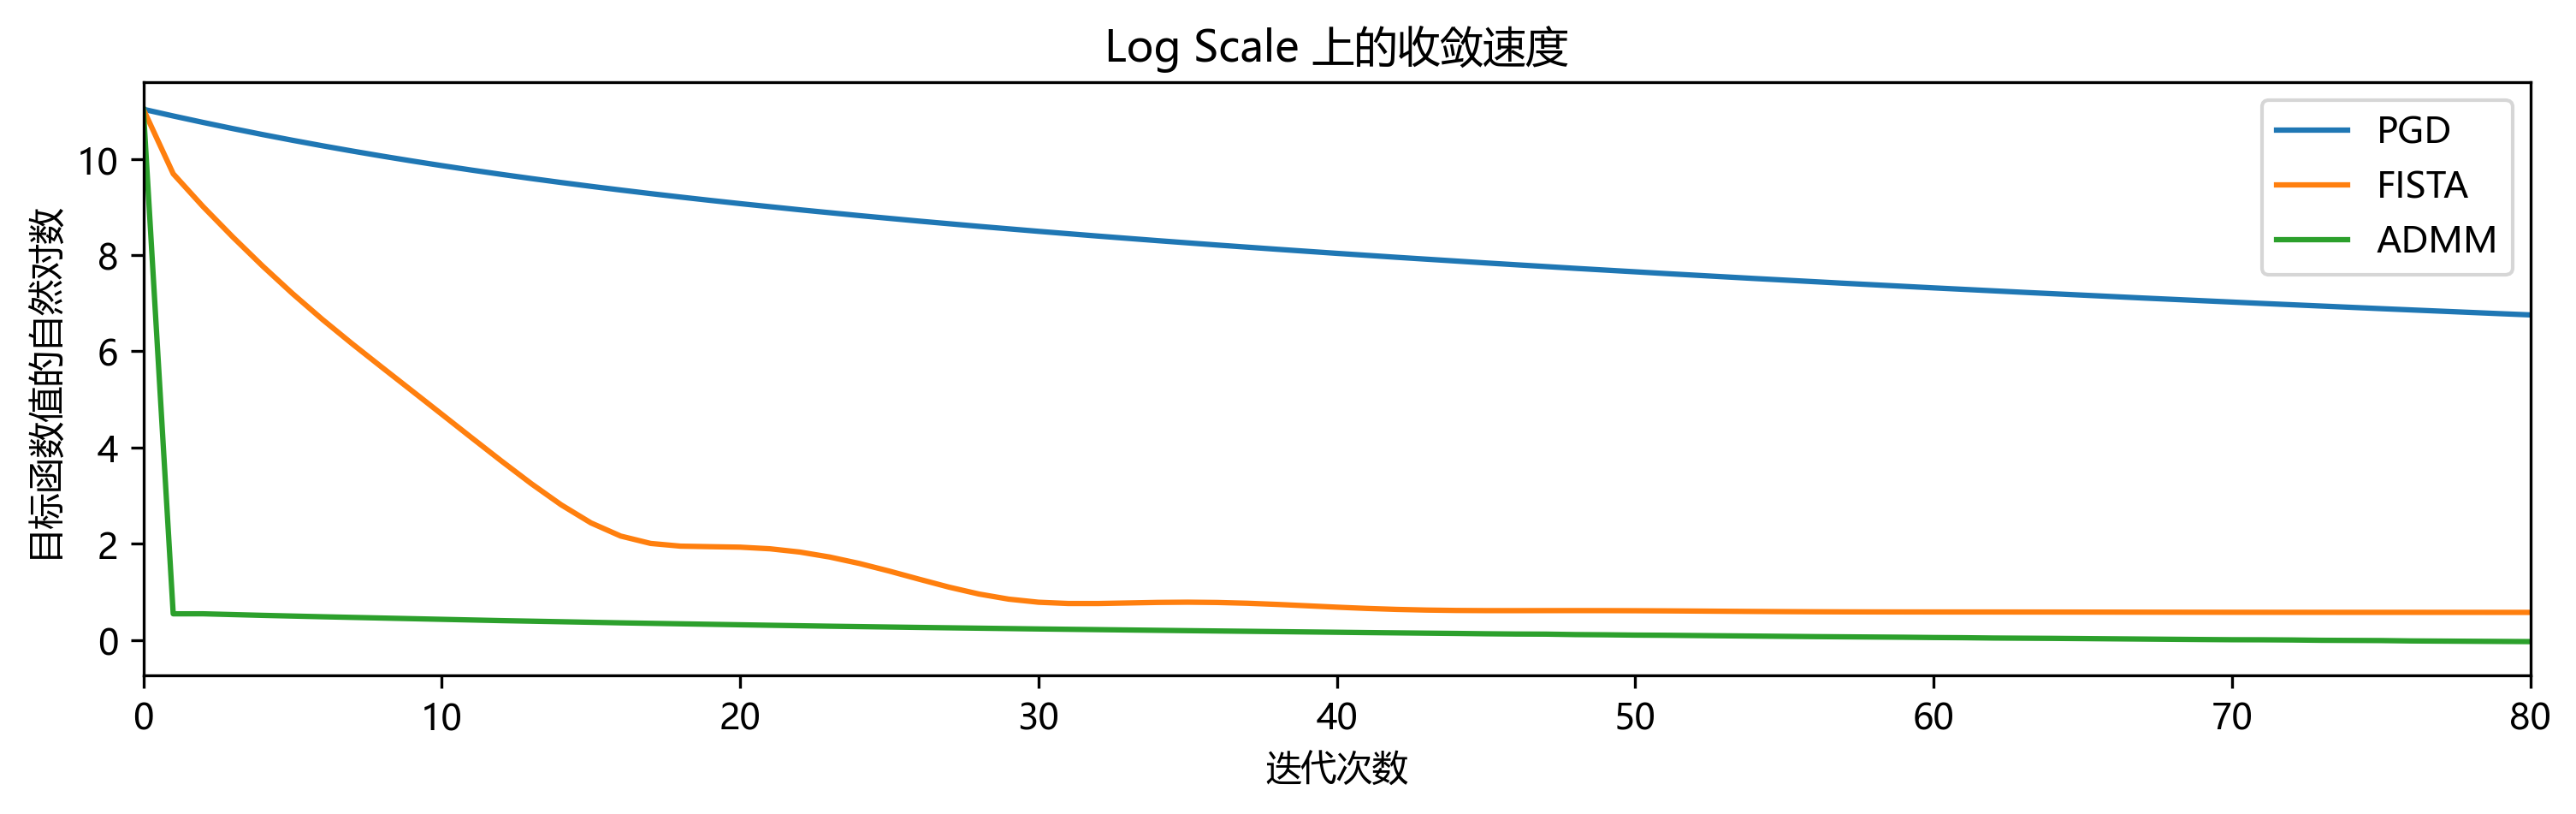

In [38]:
alldraw(80)
plt.savefig('80',dpi=500,bbox_inches='tight')
plt.show()

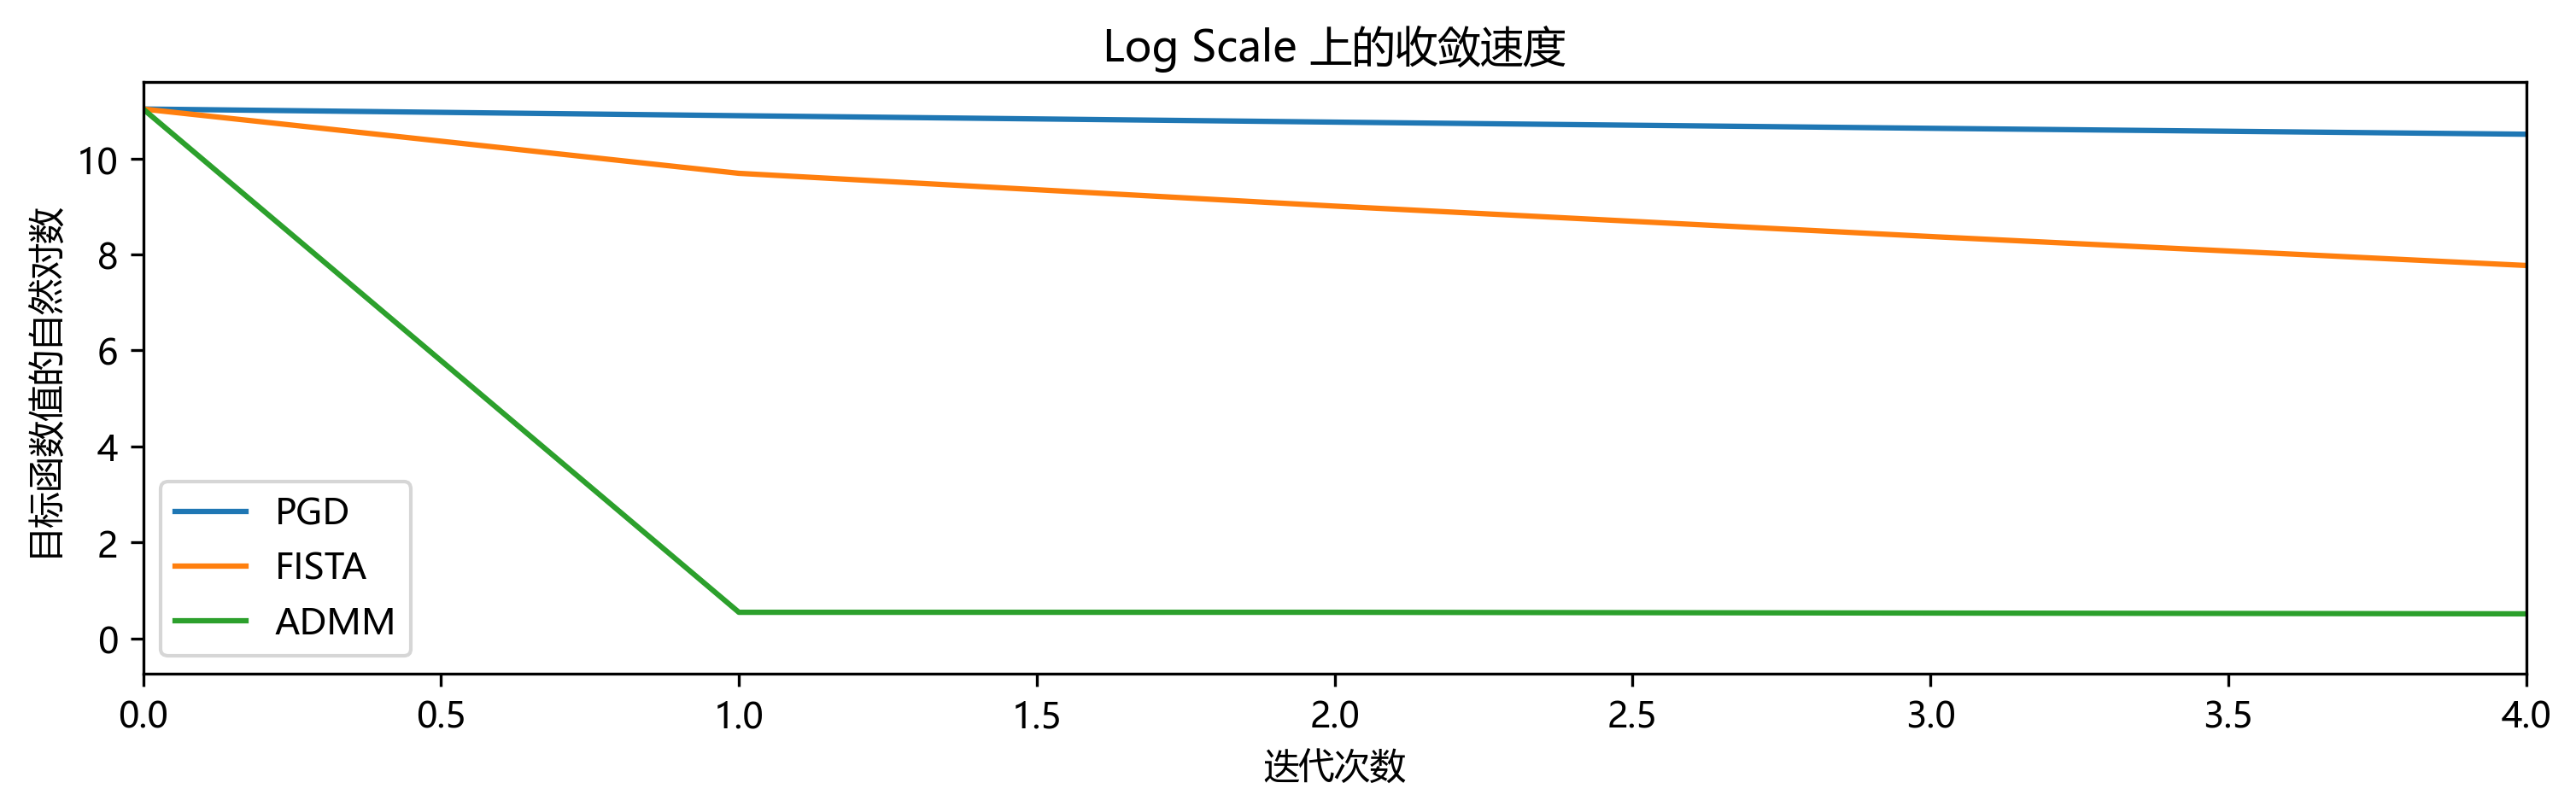

In [39]:
alldraw(4)
plt.savefig('4',dpi=500,bbox_inches='tight')
plt.show()

{{< pagebreak >}}

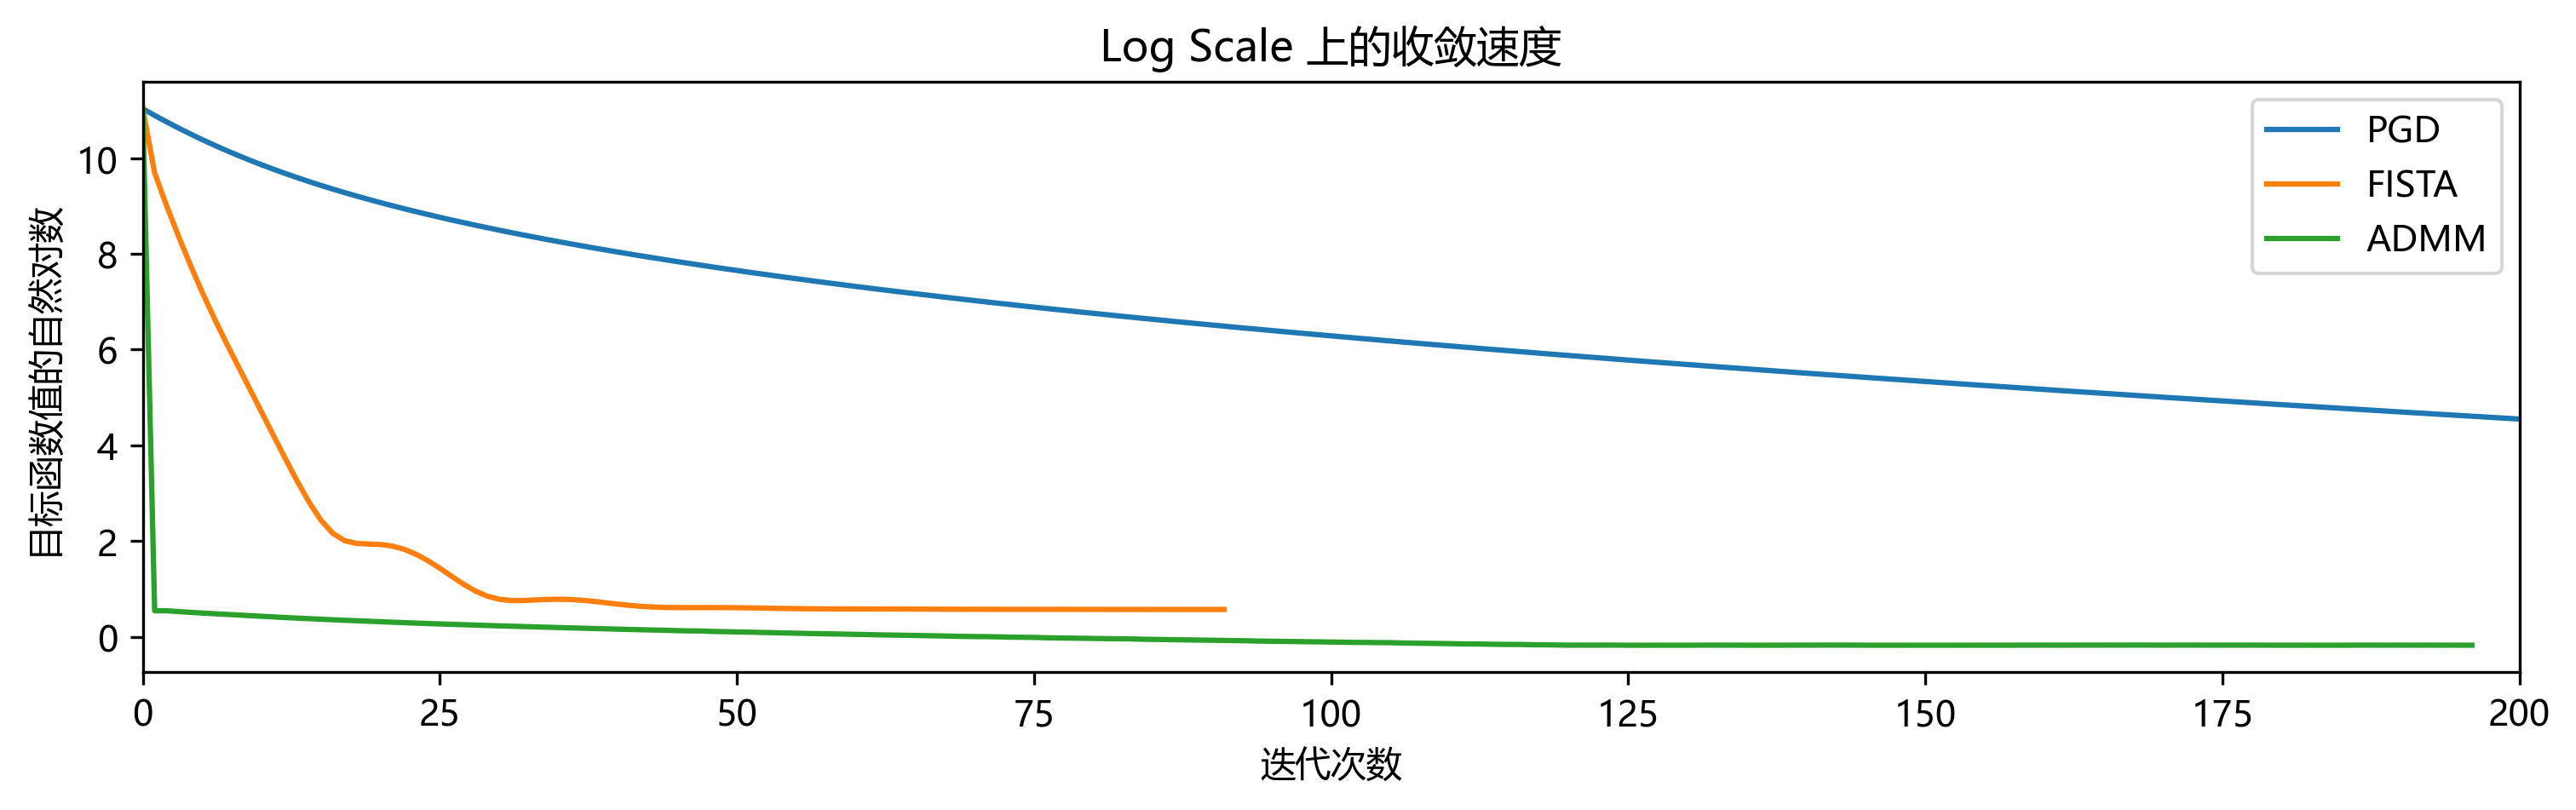

In [40]:
alldraw(200)
plt.savefig('200',dpi=500,bbox_inches='tight')
plt.show()

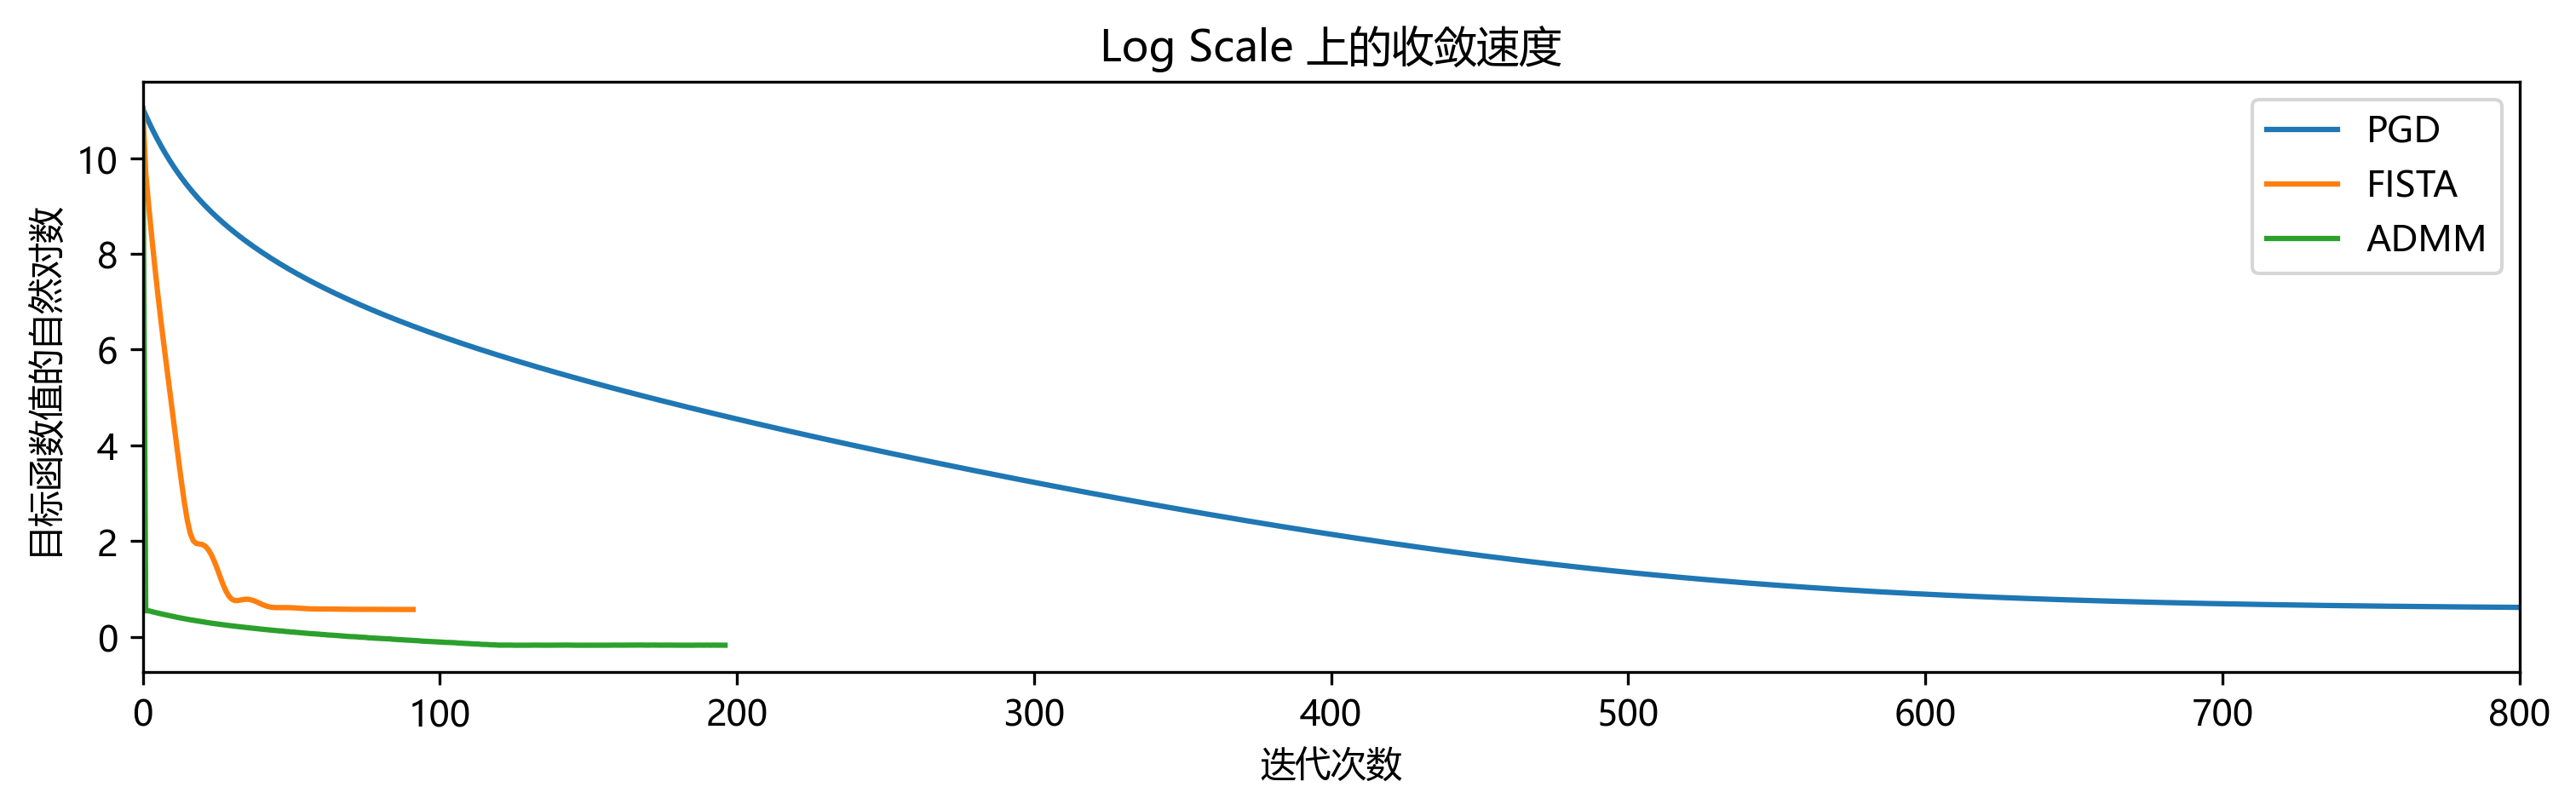

In [41]:
alldraw(800)
plt.savefig('800',dpi=500,bbox_inches='tight')
plt.show()

{{< pagebreak >}}

# 检查找到的自变量有多优

## 用 CVXPY 的结果比较

### 找到 CVXPY 结果

In [42]:
import cvxpy as cp
# 将数据转换为 NumPy 数组，因为 CVXPY 使用 NumPy
A_np = A.numpy(); b_np = b.numpy()
x = cp.Variable(n) # 定义变量
# 定义目标函数
obj = cp.Minimize(
    cp.norm(A_np@x - b_np, 2)**2 + mu*cp.norm(x, 1) 
    )
problem = cp.Problem(obj) # 定义问题
problem.solve() # 解决问题
print("最终找到的 x\n", x.value)
print("最终向下找到的目标函数自然对数值", np.log(problem.value))

最终找到的 x
 [-2.03295226e-10 -2.35416950e-10  5.29574432e-10 ...  7.08918339e-10
  8.83934837e-11 -4.95711989e-11]
最终向下找到的目标函数自然对数值 -0.19062034860889124


{{< pagebreak >}}

### 比较找到的 x 的方向和位置

用余弦相似度比较方向，用欧几里得距离比较位置

#### ISTA 和 CVXPY

In [43]:
x_star_PGD = x_star_PGD.cpu()
similarity = cosine_similarity(x.value, x_star_PGD.detach().numpy())
print("余弦相似度:", similarity)
distance = np.linalg.norm(x.value - x_star_PGD.detach().numpy())
print("欧几里得距离:", distance)

余弦相似度: 0.6960036213820899
欧几里得距离: 8.263830775789481


#### FISTA 和 CVXPY

In [44]:
x_star_FISTA = x_star_FISTA.cpu()
similarity = cosine_similarity(x.value, x_star_FISTA.detach().numpy())
print("余弦相似度:", similarity)
distance = np.linalg.norm(x.value - x_star_FISTA.detach().numpy())
print("欧几里得距离:", distance)

余弦相似度: 0.6981356313569587
欧几里得距离: 8.240015587019371


#### ADMM 和 CVXPY

In [45]:
x_star_ADMM = x_star_ADMM.cpu()
similarity = cosine_similarity(x.value, x_star_ADMM.detach().numpy())
print("余弦相似度:", similarity)
distance = np.linalg.norm(x.value - x_star_ADMM.detach().numpy())
print("欧几里得距离:", distance)

余弦相似度: 0.9999999198404822
欧几里得距离: 0.005486678363559426
